In [31]:
#Coding our own Feed Forward Neural Network using python.
#aggiunta grid search.
#Point b)

#Importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns

#Setting the random seed, obtaining always the same output for random generated variables
np.random.seed(2023)
#Generating our dataset, we choose to use the Franke Function.
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

x = np.arange(0, 1, 0.1)
y = np.arange(0, 1, 0.1)
x, y = np.meshgrid(x,y)

#np.random.normal() adds noise to z with a normal distribution.
z = FrankeFunction(x, y) + 0.01*np.random.normal(0,1, x.shape)


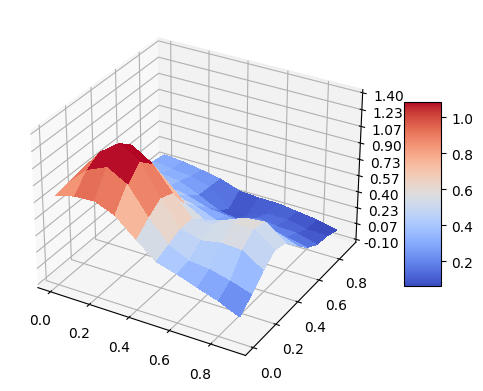

In [32]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [33]:
x = x.reshape(-1,1) #reshaping the meshgrid in two arrays
y = y.reshape(-1,1)
z = z.reshape(-1,1)
X = np.hstack((x,y))

In [34]:
# Hold out some test data that is not used in training.
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

In [35]:
#Initializing the layers size, we chose to use one hidden layer.
#The number of nodes in the hidden layer is 7, we decided by trying with different numbers, but with 7 nodes we got the best results.
#the output is only one node since we have one possible output.
n_inputs, n_features = X_train.shape
hid = 10
out = 1

In [36]:
#Initializing weights and bias in the hidden layer
hidden_weights = np.random.randn(n_features, hid)
hidden_bias = np.zeros(hid) + 0.01

#Initializing weights and bias in the output layer
output_weights = np.random.randn(hid, out)
output_bias = np.zeros(out) + 0.01

In [37]:
#define the ReLu function
def relu(X):
    return np.where(X > np.zeros(X.shape), X, np.zeros(X.shape))

#define linear function, we'll use it for the output since we have a continous output.
#It's here just for showing how it's defined, but since the linear funcion is just returning the value of the parameter, we won't need to use it later in the code.
def linear(x):
    return x

clip_value = 0.5

In [38]:
#we now define the cost/loss function. We use the MSE.
def MSE(y_data,y_model):
    n = np.size(y_model)
    y_data = y_data.reshape(-1,1)
    y_model = y_model.reshape(-1,1)
    return np.sum((y_data-y_model)**2)/n

#We define the R square
def rsquare(y, ypredict):
    y = y.reshape(-1, 1)
    ypredict = ypredict.reshape(-1,1)
    return 1-(np.sum((y-ypredict)**2)/np.sum((y-np.mean(y))**2))


In [39]:
#We now write the feed forward pass
def feed_forward(X):
    # weighted sum of inputs to the hidden layer
    z_h = np.matmul(X, hidden_weights) + hidden_bias
    # activation in the hidden layer
    a_h = relu(z_h)
    # weighted sum of inputs to the output layer
    z_o = np.matmul(a_h, output_weights) + output_bias
    
    return z_o

#feed forward stops before the output
def feed_forw_hid(X):
    # weighted sum of inputs to the hidden layer
    z_h = np.matmul(X, hidden_weights) + hidden_bias
    # activation in the hidden layer
    a_h = relu(z_h)
    return a_h

In [40]:
#We define the backpropagation algorithm
def backpropagation(X,Y):
    a_h = feed_forw_hid(X)
    #output error
    output_error = feed_forward(X) - Y
    #hidden error
    hidden_error = np.matmul(output_error, output_weights.T) * a_h * (1 - a_h)

    # gradients for the output layer
    output_weights_gradient = np.matmul(a_h.T, output_error)
    output_weights_gradient = np.clip(output_weights_gradient, -clip_value, clip_value)
    output_bias_gradient = np.sum(output_error, axis=0)
    output_bias_gradient = np.clip(output_bias_gradient, -clip_value, clip_value)
    
    # gradient for the hidden layer
    hidden_weights_gradient = np.matmul(X.T, hidden_error)
    hidden_weights_gradient = np.clip(hidden_weights_gradient, -clip_value, clip_value)
    hidden_bias_gradient = np.sum(hidden_error, axis=0)
    hidden_bias_gradient = np.clip(hidden_bias_gradient, -clip_value, clip_value)
    #Updated weights and bias are returned
    return output_weights_gradient, output_bias_gradient, hidden_weights_gradient, hidden_bias_gradient


In [41]:
#We code the learning algorithm
num_epochs = 1000
#eta and lambda are chosen by trying and choosing the values that give us the best outputs.
eta = [0.001, 0.003, 0.005, 0.007, 0.009, 0.011, 0.013, 0.015]
lmbd = [0.001, 0.003, 0.005, 0.007, 0.009, 0.011, 0.013, 0.015]
loss_train = np.zeros((len(lmbd),len(eta)))
r2_train = np.zeros((len(lmbd),len(eta)))
loss_test = np.zeros((len(lmbd),len(eta)))
r2_test = np.zeros((len(lmbd),len(eta)))

In [42]:
#defining the learning
def learn(ld, et, o_w, o_b, h_w, h_b):
        for epoch in range(num_epochs):
                # calculate gradients
                dWo, dBo, dWh, dBh = backpropagation(X_train, z_train)    
                #regularization term gradients
                dWo += ld * output_weights
                dWh += ld * hidden_weights

                #update weights and biases
                o_w -= et * dWo
                o_b -= et * dBo
                h_w -= et * dWh
                h_b -= et * dBh
                #we find the loss by calculating the mse with the predicted value and the actual value.
        ls = MSE(z_train, feed_forward(X_train))
        r = rsquare(z_train, feed_forward(X_train))
        ls_test = MSE(z_test, feed_forward(X_test))
        r_test = rsquare(z_test, feed_forward(X_test))
        return ls, r, ls_test, r_test

In [43]:

loss_best = 1
for i in range(len(lmbd)):
    for j in range(len(eta)):
        loss_train[j][i], r2_train[j][i], loss_test[j][i], r2_test[j][i] = learn(lmbd[i], eta[j], output_weights, output_bias, hidden_weights, hidden_bias)
        if loss_test[j][i] < loss_best:
            loss_best = loss_test[j][i]
            best_lmbd = lmbd[i]
            best_eta = eta[j]
            j_b = j
            i_b = i
        print(f'TRAIN {j},{i} Loss: {loss_train[j][i]}, R2 {r2_train[j][i]}')
        print(f'TEST {j},{i} Loss: {loss_test[j][i]}, R2 {r2_test[j][i]}')


TRAIN 0,0 Loss: 0.05557920202809652, R2 0.23756680924800078
TEST 0,0 Loss: 0.04536713114374484, R2 0.5026948368487809
TRAIN 1,0 Loss: 0.01846639535103195, R2 0.7466787536449744
TEST 1,0 Loss: 0.028883580992881484, R2 0.6833841242342507
TRAIN 2,0 Loss: 0.0185018858841977, R2 0.7461918959813942
TEST 2,0 Loss: 0.0414551911777243, R2 0.5455767183782867
TRAIN 3,0 Loss: 0.025552209636106427, R2 0.6494758468505522
TEST 3,0 Loss: 0.043839627144804896, R2 0.519439021597869
TRAIN 4,0 Loss: 0.0199978442335351, R2 0.7256704013233596
TEST 4,0 Loss: 0.03265190402589931, R2 0.6420765419936263
TRAIN 5,0 Loss: 0.020601703167512274, R2 0.7173866894851872
TEST 5,0 Loss: 0.031811213160863896, R2 0.6512920223922325
TRAIN 6,0 Loss: 0.020541199040177767, R2 0.7182166825972509
TEST 6,0 Loss: 0.032244732354307686, R2 0.646539874134463
TRAIN 7,0 Loss: 0.02115472496782642, R2 0.7098003593404008
TEST 7,0 Loss: 0.03164107023655261, R2 0.653157094143531
TRAIN 0,1 Loss: 0.015256966889053087, R2 0.7907055603184461
TE

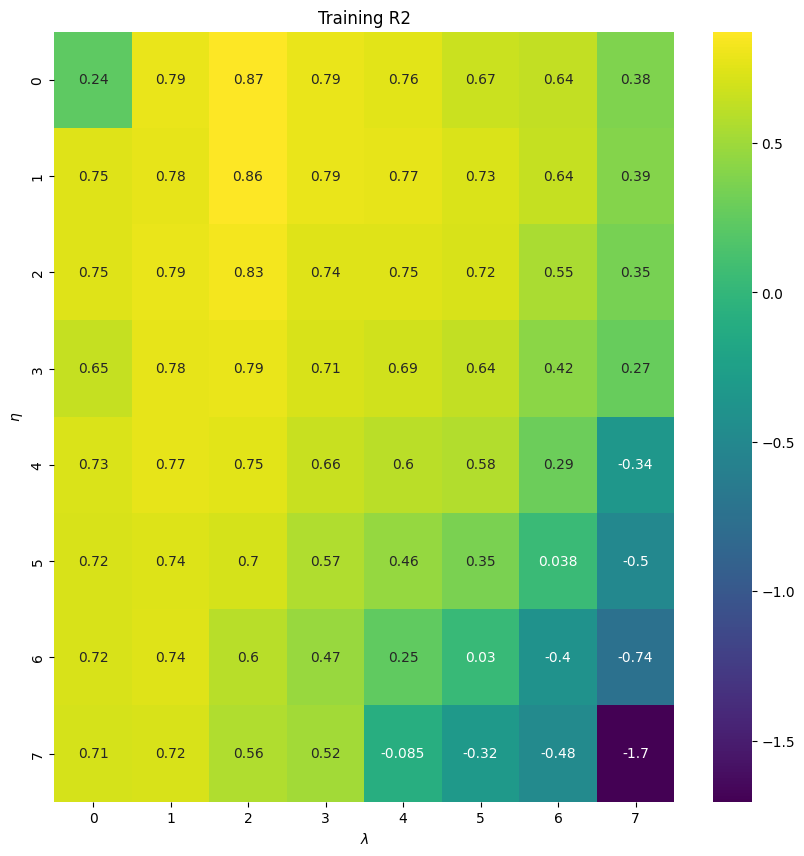

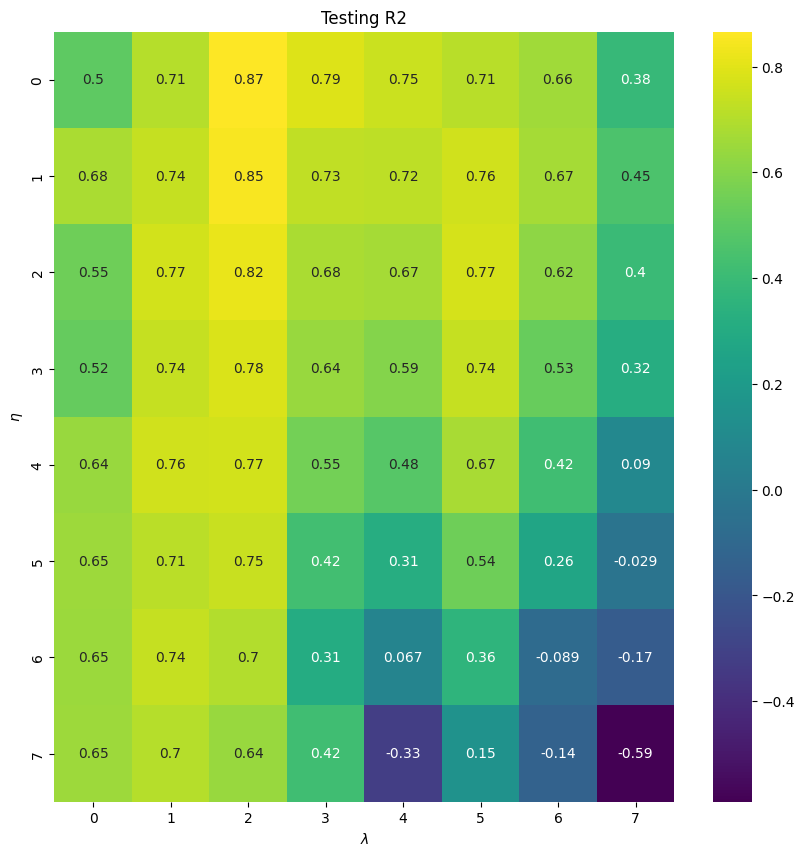

In [44]:
#plottiamo la grid search
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(r2_train, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training R2")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(r2_test, annot=True, ax=ax, cmap="viridis")
ax.set_title("Testing R2")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

In [45]:
print(f'The best parameters are:')
print(f'Lambda = {best_lmbd}')
print(f'Eta = {best_eta}')
print(f'{j_b},{i_b}')
print(f'The results with these parameters are:')
print(f'MSE: {loss_test[j_b][i_b]}')
print(f'R2: {r2_test[j_b][i_b]}')

The best parameters are:
Lambda = 0.005
Eta = 0.001
0,2
The results with these parameters are:
MSE: 0.012235528985122614
R2: 0.8658766471499304
